In [1]:

import re
import seaborn as sbn
import nltk
import tqdm as tqdm
import sqlite3
import pandas as pd
import numpy as np

import string
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words("english")
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from math import floor,ceil
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from gensim import summarization
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\15726\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\15726\anaconda3\envs\ds-1\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
review_data_or = pd.read_json('Video_Games_5.json',lines=True)

In [3]:
review_data_or.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [4]:
review_data_or.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231780 entries, 0 to 231779
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      231780 non-null  object
 1   asin            231780 non-null  object
 2   reviewerName    228967 non-null  object
 3   helpful         231780 non-null  object
 4   reviewText      231780 non-null  object
 5   overall         231780 non-null  int64 
 6   summary         231780 non-null  object
 7   unixReviewTime  231780 non-null  int64 
 8   reviewTime      231780 non-null  object
dtypes: int64(2), object(7)
memory usage: 15.9+ MB


In [5]:
review_data=review_data_or.drop(['reviewerID','asin','reviewerName','summary'],axis=1)


In [6]:
from datetime import datetime
current_date = datetime.now()
# Define a function to calculate the time difference in days
def calculate_time_difference(review_time):
    return (current_date - datetime.strptime(review_time, "%m %d, %Y")).days

# Apply the function to the 'reviewTime' column and replace it
review_data['Review_Interval_Days'] = review_data['reviewTime'].apply(calculate_time_difference)
review_data = review_data.drop(['reviewTime'],axis=1)


In [7]:
review_data['reviewText'] = review_data['reviewText'].astype('string')


In [8]:
review_data.head()

,helpful,reviewText,overall,unixReviewTime,Review_Interval_Days
0,"[8, 12]",Installing the game was a struggle (because of...,1,1341792000,4121
1,"[0, 0]",If you like rally cars get this game you will ...,4,1372550400,3765
2,"[0, 0]",1st shipment received a book instead of the ga...,1,1403913600,3402
3,"[7, 10]","I got this version instead of the PS3 version,...",3,1315958400,4420
4,"[2, 2]",I had Dirt 2 on Xbox 360 and it was an okay ga...,4,1308009600,4512


In [9]:
reviews = review_data

reviews[['helpful','total']] = pd.DataFrame(reviews.helpful.values.tolist(), index=reviews.index)
############删掉没有评价是否有用的评论############################
reviews = reviews[reviews['total'] > 0]
#reviews["sentiment"] = reviews["overall"].apply(lambda score: 1 if score > 3 else 1)
reviews["usefulScore"] = (reviews["helpful"]/reviews["total"]).apply(lambda n: n if n > 0 else 0)
#.apply(lambda n: "useful" if n > 0.8 else "useless")

review_data = reviews.drop(['helpful','total'],axis=1)
review_data.head(10)


C:\Users\15726\AppData\Local\Temp\ipykernel_20748\3796216857.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews["usefulScore"] = (reviews["helpful"]/reviews["total"]).apply(lambda n: n if n > 0 else 0)


,reviewText,overall,unixReviewTime,Review_Interval_Days,usefulScore
0,Installing the game was a struggle (because of...,1,1341792000,4121,0.666667
3,"I got this version instead of the PS3 version,...",3,1315958400,4420,0.700000
4,I had Dirt 2 on Xbox 360 and it was an okay ga...,4,1308009600,4512,1.000000
6,Loved playing Dirt 2 and I thought the graphic...,5,1313280000,4451,0.846154
7,I can't tell you what a piece of dog**** this ...,1,1353715200,3983,0.250000
8,I initially gave this one star because it was ...,4,1352851200,3993,0.000000
9,I still haven't figured this one out. Did ever...,2,1391817600,3542,1.000000
10,I'm not quite finished with the game's DiRT To...,5,1309219200,4498,1.000000
12,Dirt 3 on DVDi collect racing games so had to ...,5,1388275200,3583,0.000000
15,"This game was a rip-off. It has less terrain,...",1,1373846400,3750,1.000000


In [10]:
a = review_data['overall'].value_counts()
print(a)

5    63594
4    32278
3    19723
1    13239
2    11021
Name: overall, dtype: int64


# Data Cleaning

In [11]:
count = 0
for i in review_data['reviewText']:
    if i == '':
        
        count = count+1
count

40

In [12]:
review_data = review_data[review_data['reviewText'] != '']

In [13]:
import nltk
#nlp = spacy.load("en_core_web_sm")
# 下载NLTK的punkt句子分割模型（只需要执行一次）
nltk.download('punkt')

from nltk.tokenize import sent_tokenize

def split_sentences(text):

  try:
   punctuation = ['.', '!', '?']
    
        # 去除句子末尾的空格
   text = text.rstrip()
    
     # 检查句末是否有标点符号
   if text[-1] not in punctuation:
        # 如果没有标点符号，就添加一个句号
      text = f'{text}.'
   #sentences = sent_tokenize(text)

   return text
  except Exception as e:
    print(f"Error: {e}, Text: {text}")


review_data['reviewText']= review_data['reviewText'].apply(split_sentences)
#sample =split_sentences( review_data['reviewText'][9827])
#sample


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\15726\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
review_data.head()

,reviewText,overall,unixReviewTime,Review_Interval_Days,usefulScore
0,Installing the game was a struggle (because of...,1,1341792000,4121,0.666667
3,"I got this version instead of the PS3 version,...",3,1315958400,4420,0.700000
4,I had Dirt 2 on Xbox 360 and it was an okay ga...,4,1308009600,4512,1.000000
6,Loved playing Dirt 2 and I thought the graphic...,5,1313280000,4451,0.846154
7,I can't tell you what a piece of dog**** this ...,1,1353715200,3983,0.250000


# SMOG指数可读性分析
SMOG指数是一种用于评估文本可读性的指标，它考虑了一个文本中的多音节词的数量。SMOG代表了“Simple Measure of Gobbledygook”（即“混乱简单度量”），是由罗伯特·克拉斯特（Robert Gunning）于1952年提出的。它旨在提供一个简单但有效的方法来估计一段文本的阅读难易程度。

In [15]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139815 entries, 0 to 231779
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   reviewText            139815 non-null  object 
 1   overall               139815 non-null  int64  
 2   unixReviewTime        139815 non-null  int64  
 3   Review_Interval_Days  139815 non-null  int64  
 4   usefulScore           139815 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 6.4+ MB


In [16]:
sample_data = review_data.sample(n=10000, random_state=42)

In [17]:
sample_data

,reviewText,overall,unixReviewTime,Review_Interval_Days,usefulScore
39633,You get more Nazis to shoot. The weapons are p...,4,1074297600,7217,0.000000
106693,This is one of those games that you can actual...,4,1233964800,5369,0.727273
38393,Talk about a game that is perfect in just abou...,5,1075334400,7205,0.900000
173216,"A fun game with an entertaining story line, pr...",5,1334620800,4204,1.000000
134612,This is a launch title that's $40 and it took ...,3,1301961600,4582,0.285714
...,...,...,...,...,...
141351,Alan Wake is a very entertaining experience an...,5,1275091200,4893,0.800000
222470,the game of course is awesome so I won't spend...,5,1373587200,3753,1.000000
198512,My six year old daughter doesn't like this gam...,1,1404172800,3399,1.000000
59944,"Circa 1988-89, many NES titles try to create a...",3,1340409600,4137,0.333333


In [18]:
sample_data.reviewText

39633     You get more Nazis to shoot. The weapons are p...
106693    This is one of those games that you can actual...
38393     Talk about a game that is perfect in just abou...
173216    A fun game with an entertaining story line, pr...
134612    This is a launch title that's $40 and it took ...
                                ...                        
141351    Alan Wake is a very entertaining experience an...
222470    the game of course is awesome so I won't spend...
198512    My six year old daughter doesn't like this gam...
59944     Circa 1988-89, many NES titles try to create a...
96670     Before I get into the meat of this review, let...
Name: reviewText, Length: 10000, dtype: object

In [19]:
from textatistic import Textatistic

# 定义一个函数来计算SMOG指数
def calculate_smog(text):
    try:
        stats = Textatistic(text)
        return stats.smog_score
    except Exception as e:
        print(f"Error calculating SMOG for text: {e}/n{text}")
        return 0

# 示例用法
readability_scores = []

for i in sample_data.reviewText:
    smog = calculate_smog(i)
    readability_scores.append(smog)

sample_data['Readability_smog'] = readability_scores


Error calculating SMOG for text: Word to be hyphenated may have at most 100 characters./nSummary:---Having played this game for several months during the closed beta, I can only state that the game keeps getting better. At first impression, gameplay was already an amazing experience.---The game consists of a matching system, where you are matched with other players to form a team. You each select a hero and are placed against another team of heroes to invade the enemy base while defending your own.---By purchasing the collector pack, you are giving yourself a head start into the world of LoL. You will not regret the purchase and even if you do, the Riot staff has superior customer service and will complete your satisfaction.Pros:---The characters are very lively and fun to play. Each has their own fun attitude and great sound clips. While the graphics felt a bit childish at first and too bright, I've grown quite fond of them as they are quite personal. Animations are great.---The gamep

In [20]:
from textstat import flesch_kincaid_grade, gunning_fog


# 示例用法
flesch_scores = []
gunning_scores = []

for i in sample_data.reviewText:
    fk_score = flesch_kincaid_grade(i)
    gf_score = gunning_fog(i)
    flesch_scores.append(fk_score)
    gunning_scores.append(gf_score)

sample_data['Readability_flesch'] = flesch_scores
sample_data['Readability_Gunning'] = gunning_scores

In [21]:
###字符
##单词数
sample_data['Readability_char_count'] = sample_data['reviewText'].apply(len)

# 计算单词数并添加为新列 'Word_Count'
sample_data['Word_Count'] = sample_data['reviewText'].apply(lambda x: len(x.split()))


## Test of SentimentIntensity Analysis极性分析


In [22]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
#sample_review = review_data.reviewText[:10]
Review_Polarity = []
for test in sample_data.reviewText:
    ss = analyser.polarity_scores(test) #极性分析
    #for k in sorted(ss):
        #print('{0}: {1}, '.format(k, ss[k]))
    Review_Polarity.append(ss['compound'])
    #print(test)
Review_Polarity[:10]
sample_data['Polarity'] = Review_Polarity

# 主观性分析 TextBlob


In [23]:
from textblob import TextBlob, Word, Blobber
sample_data['Subjectivity'] = sample_data['reviewText'].apply(lambda x: TextBlob(x).sentiment[1])



In [24]:
sample_data = sample_data.drop(['reviewText'],axis=1)

In [25]:
sample_data

,overall,unixReviewTime,Review_Interval_Days,usefulScore,Readability_smog,Readability_flesch,Readability_Gunning,Readability_char_count,Word_Count,Polarity,Subjectivity
39633,4,1074297600,7217,0.000000,6.427356,2.4,5.26,147,29,0.3193,0.532143
106693,4,1233964800,5369,0.727273,9.642633,8.4,10.86,1472,270,0.9918,0.517241
38393,5,1075334400,7205,0.900000,8.124752,6.1,8.52,1447,262,0.9966,0.561651
173216,5,1334620800,4204,1.000000,8.076483,6.7,9.94,357,71,0.9552,0.456548
134612,3,1301961600,4582,0.285714,8.344100,8.5,10.15,1409,269,0.9322,0.525446
...,...,...,...,...,...,...,...,...,...,...,...
141351,5,1275091200,4893,0.800000,8.401726,6.3,7.94,1530,266,0.9951,0.552821
222470,5,1373587200,3753,1.000000,7.168622,5.3,6.92,535,100,0.3940,0.537056
198512,1,1404172800,3399,1.000000,3.129100,1.3,2.80,102,21,-0.4218,0.495000
59944,3,1340409600,4137,0.333333,12.404819,11.3,13.89,1729,292,-0.9441,0.525057


# distribution of usefulScore is heavily skewed towards 0

In [26]:
sample_data.describe()

,overall,unixReviewTime,Review_Interval_Days,usefulScore,Readability_smog,Readability_flesch,Readability_Gunning,Readability_char_count,Word_Count,Polarity,Subjectivity
count,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.860500,1.246915e+09,5219.118000,0.622956,7.876706,7.014770,9.076848,1470.473100,265.669100,0.569526,0.502350
std,1.327183,1.180323e+08,1366.115021,0.368580,2.134045,4.207117,4.269959,1811.822851,322.856658,0.643653,0.097433
min,1.000000,9.398592e+08,3383.000000,0.000000,0.000000,-3.500000,0.400000,14.000000,1.000000,-0.999900,0.000000
25%,3.000000,1.164240e+09,4022.000000,0.333333,6.742158,4.900000,7.030000,373.750000,70.000000,0.460250,0.453432
50%,4.000000,1.274832e+09,4896.000000,0.700000,7.957252,6.500000,8.560000,858.000000,158.000000,0.916000,0.500000
75%,5.000000,1.350346e+09,6176.000000,1.000000,9.112423,8.300000,10.280000,1857.250000,334.000000,0.982200,0.549579
max,5.000000,1.405555e+09,8773.000000,1.000000,34.419100,129.200000,134.270000,24293.000000,4497.000000,1.000000,1.000000


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
b = sample_data.usefulScore.value_counts().sort_index()
b



0.000000    1556
0.006329       1
0.011236       1
0.012987       1
0.013158       1
            ... 
0.988095       1
0.988372       2
0.990099       1
0.990291       1
1.000000    3220
Name: usefulScore, Length: 620, dtype: int64

In [28]:
bins = pd.cut(sample_data['usefulScore'], bins=10)

# 计算每个区间的计数
counts = bins.value_counts().sort_index()
counts

(-0.001, 0.1]    1688
(0.1, 0.2]        288
(0.2, 0.3]        341
(0.3, 0.4]        531
(0.4, 0.5]       1108
(0.5, 0.6]        336
(0.6, 0.7]        733
(0.7, 0.8]        802
(0.8, 0.9]        571
(0.9, 1.0]       3602
Name: usefulScore, dtype: int64

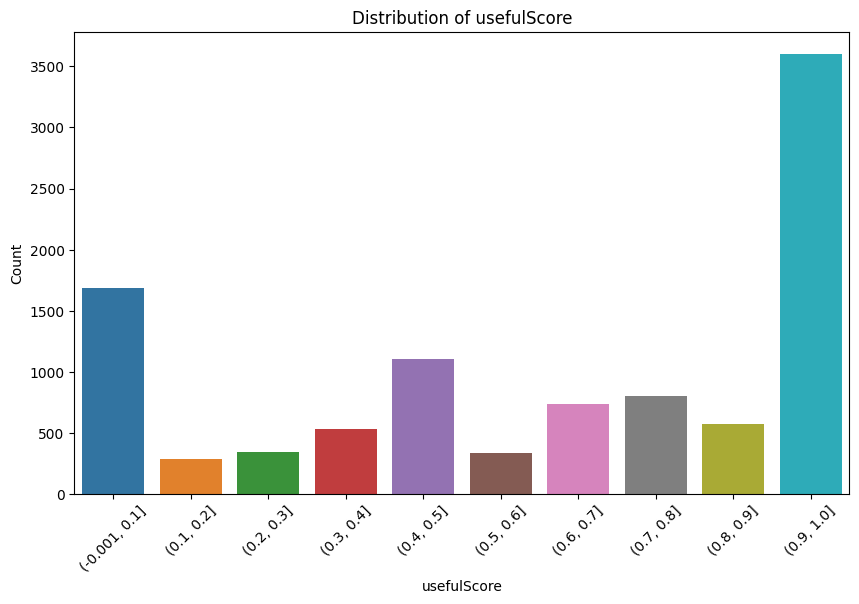

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 sample_data 包含了你的数据
# 例如：sample_data = pd.read_csv('your_data.csv')

# 将 usefulScore 列的值分成十个区间
bins = pd.cut(sample_data['usefulScore'], bins=10)

# 计算每个区间的计数
counts = bins.value_counts().sort_index()

# 绘制 barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel('usefulScore')
plt.ylabel('Count')
plt.title('Distribution of usefulScore')
plt.xticks(rotation=45)
plt.show()


# 样本不均衡，AUC=0.5


In [30]:
b

0.000000    1556
0.006329       1
0.011236       1
0.012987       1
0.013158       1
            ... 
0.988095       1
0.988372       2
0.990099       1
0.990291       1
1.000000    3220
Name: usefulScore, Length: 620, dtype: int64

In [31]:
from sklearn.preprocessing import MinMaxScaler

# 初始化MinMaxScaler
scaler = MinMaxScaler()


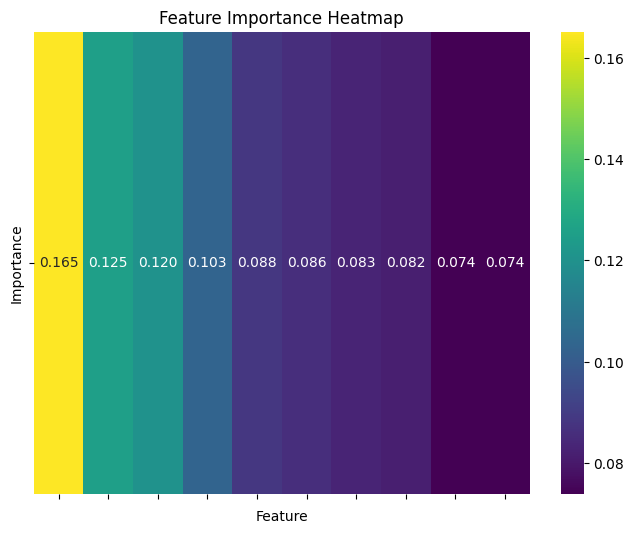

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Assuming 'data' contains the features and labels (overall, Review_Interval_Days, Readability, Polarity)
# X contains the features, y contains the labels


y = sample_data['usefulScore'].values
X = sample_data.drop(columns='usefulScore')

#######数不需要归一化

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X, y)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame with feature names and their importances
importance_df = pd.DataFrame({'Feature': sample_data.columns.tolist().remove('usefulScore'),
                              'Importance': feature_importances})


# Create the heatmap
plt.figure(figsize=(8, 6))
heatmap_data = importance_df.set_index('Feature')['Importance'].sort_values(ascending=False).to_frame().T
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='.3f')
plt.title('Feature Importance Heatmap')
plt.show()

In [33]:
# 不用交叉验证，没必要，时间长，结果差不多
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


y = sample_data['usefulScore'].values
X = sample_data.drop(columns='usefulScore')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [34]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
threshold = 0.4

In [35]:
#################处理样本不平衡

from sklearn.utils import resample

# 将数据分成特征 (X) 和目标 (y)
# 替换成你的特征数据
y = sample_data['usefulScore']  # 替换成你的目标数据

y.value_counts()


1.000000    3220
0.000000    1556
0.500000     948
0.666667     494
0.333333     330
            ... 
0.897436       1
0.901408       1
0.899395       1
0.890710       1
0.643678       1
Name: usefulScore, Length: 620, dtype: int64

# 平衡样本

In [36]:

# 将数据分成正例和负例
positive_samples = sample_data[y > threshold]
negative_samples = sample_data[y <= threshold]

# 从负例中随机采样生成合成样本
synthetic_samples = resample(negative_samples, n_samples=len(positive_samples), random_state=42)

# 将正例和合成样本合并
balanced_data = pd.concat([positive_samples, synthetic_samples])

# balanced_data 包含了处理后的平衡数据，你可以将其用于训练模型
X = balanced_data.drop(columns='usefulScore')
y = balanced_data['usefulScore'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_binary = (y_train > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)

In [37]:
balanced_data['usefulScore'].value_counts()

0.000000    3853
1.000000    3220
0.500000     948
0.333333     840
0.666667     494
            ... 
0.822581       1
0.627027       1
0.915789       1
0.814815       1
0.015385       1
Name: usefulScore, Length: 611, dtype: int64

In [38]:

##################随机森林

##过拟合，减少树的数量

rf_model = RandomForestClassifier(n_estimators=20, random_state=42)  #100->10

# 使用交叉验证评估模型性能
# cv 参数指定了将数据集分成几份进行交叉验证，这里使用了 5 折交叉验证
# scoring 参数指定了评估指标，比如 'accuracy' 代表准确率
scores = cross_val_score(rf_model, X_train, y_train_binary, cv=5, scoring='accuracy')
rf_model.fit(X_train,y_train_binary)

# 输出交叉验证的结果
print("Cross-validated Accuracy:", scores)
print("Mean Accuracy:", scores.mean())

# 在测试集上评估模型性能
accuracy = rf_model.score(X_test, y_test_binary)
print(f'Test Accuracy: {accuracy}')

Cross-validated Accuracy: [0.84971603 0.82743556 0.83704675 0.83522727 0.83784965]
Mean Accuracy: 0.8374550525926672
Test Accuracy: 0.8650821391121986


In [39]:
y_test_binary.mean()

0.5022719328905977

In [40]:
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
# 使用 roc_auc_score 函数计算AUC
y_pred = rf_model.predict(X_test)
y_pred_binary = (rf_model.predict(X_test) > threshold).astype(int)
auc_score = roc_auc_score(y_test_binary, y_pred_binary)

print(f"AUC Score: {auc_score}")
r2 = r2_score(y_test, y_pred)
print(r2)

AUC Score: 0.8654351195921591
0.13593509674578252


# 每个变量

In [41]:


# Assuming 'data' contains the features and labels (overall, Review_Interval_Days, Readability, Polarity)
# X contains the features, y contains the labels
features = sample_data.columns.tolist()
features.remove('usefulScore')
outcome = []
threshold = 0.4

for i in features:
    X_train1 = X_train[[i]].values.reshape(-1, 1)  # Use the feature 'i'
    X_test1 = X_test[[i]].values.reshape(-1, 1) 

    # Convert usefulScore to binary labels
    y_train_binary = (y_train > threshold).astype(int)
    # Train the model
    rf_model.fit(X_train1, y_train_binary)
    y_test_binary = (y_test > threshold).astype(int)
    y_pred_binary = (rf_model.predict(X_test1) > threshold).astype(int)
    y_pred = rf_model.predict(X_test1) 

    # Evaluate the model
    accuracy = roc_auc_score(y_test_binary, y_pred_binary)
    r2 = r2_score(y_test, y_pred)
    outcome.append(f'AUC for {i}: {accuracy} ')
outcome

['AUC for overall: 0.5977660524813712 ',
 'AUC for unixReviewTime: 0.6959882968575293 ',
 'AUC for Review_Interval_Days: 0.6959787674071294 ',
 'AUC for Readability_smog: 0.6436787001634179 ',
 'AUC for Readability_flesch: 0.5824578456209488 ',
 'AUC for Readability_Gunning: 0.6383595564260749 ',
 'AUC for Readability_char_count: 0.7019986922661914 ',
 'AUC for Word_Count: 0.6355139159297226 ',
 'AUC for Polarity: 0.6955005844729579 ',
 'AUC for Subjectivity: 0.7870136070777916 ']